In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import sys

from src.plotter.Plotter import Plotter
from scipy.optimize import curve_fit
from time import sleep

<h2 align='center'>Constants</h2>

In [2]:
M = 200.59e-3
R = 8.31

<h2 align='center'>Loading data</h2>

In [3]:
data = requests.get('http://77.246.98.155/database/phase_diagram/?format=json').json()
temperature = np.array([dat['temperature'] for dat in data])
pressure = np.array([dat['pressure'] for dat in data])
density = np.array([dat['density'] for dat in data])

linearized_temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))
linearized_pressure = (pressure - min(pressure)) / (max(pressure) - min(pressure))
linearized_density = (density - min(density)) / (max(density) - min(density))

<h2 align='center'>Creating model</h2>

In [10]:
inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(2, activation='gelu')(inputs)
x = tf.keras.layers.Dense(2, activation='gelu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss="mse", metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 6         
                                                                 
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<h2 align='center'>Training model</h2>

In [11]:
x_train = np.array([linearized_temperature, linearized_pressure]).T
y_train = np.array([linearized_density]).T
model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
27/27 [==============================] - 1s 1ms/step - loss: 0.0336 - accuracy: 0.0012 
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.0012
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.0012
Epoch 4/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 0.0012
Epoch 5/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.0247 - accuracy: 0.0012
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.0012
Epoch 7/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.0230 - accuracy: 0.0012
Epoch 8/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.0223 - accuracy: 0.0012
Epoch 9/1000
27/27 [==============================] - 0s 1ms/step - loss: 0.0216 - accuracy: 0.0012
Epoch 10/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.001

<h2 align='center'>Plotting data</h2>

27/27 [==============================] - 0s 964us/step


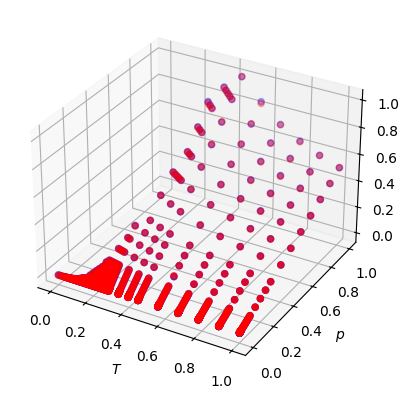

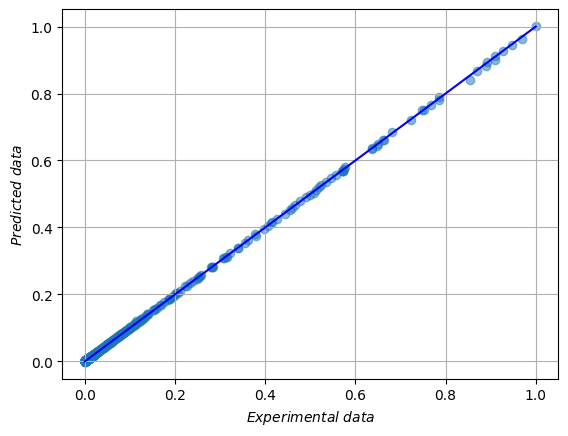

In [6]:
x_test = np.array([linearized_temperature, linearized_pressure]).T
y_test = model.predict(x_test).T

plotter = Plotter(dimension='3d')
plotter.scatter(linearized_temperature, linearized_pressure, linearized_density, color='b')
plotter.scatter(linearized_temperature, linearized_pressure, y_test, color='r')
plotter.xlabel(r'$T$')
plotter.ylabel(r'$p$')
plotter.zlabel(r'$\rho$')
plotter.show()

linear_x = np.linspace(0, 1, 100)
linear_y = linear_x

plotter = Plotter(dimension='2d')
plotter.scatter(linearized_density, y_test, alpha=0.5)
plotter.plot(linear_x, linear_y, 'b-')
plotter.xlabel(r'$Experimental$ $data$')
plotter.ylabel(r'$Predicted$ $data$')
plotter.grid(True)
plotter.show()

<h2 align='center'>MSE calculations of coefficients</h2>

In [7]:
rang = 2000

temperatures, pressures = np.meshgrid(np.linspace(0, 3, rang), np.linspace(0, 3, rang))
temperatures = temperatures.flatten()
pressures = pressures.flatten()

x_test = np.array([temperatures, pressures]).T
y_test = model.predict(x_test)

temperatures = temperatures * (max(temperature) - min(temperature)) + min(temperature)
pressures = pressures * (max(pressure) - min(pressure)) + min(pressure)
y_test = y_test.T[0] * (max(density) - min(density)) + min(density)

125000/125000 [==============================] - 119s 952us/step


<h2 align='center'>Plotting second viral coefficient</h2>

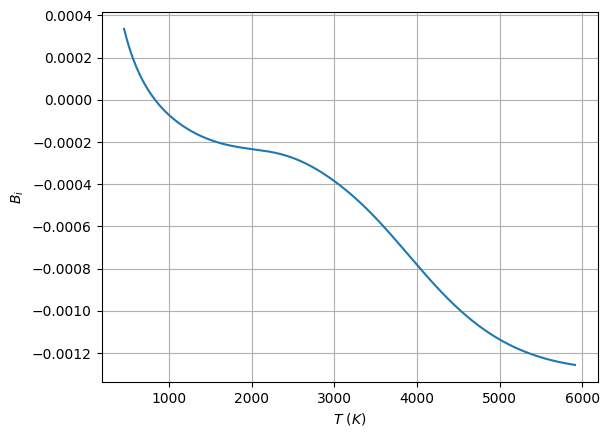

In [8]:
def mapping(x, b):
    return x + b * x ** 2

coeff = []
for i in range(rang):
    where = np.where(temperatures == temperatures[i])
    temperatures_rang = temperatures[where]
    pressures_rang = pressures[where]
    densities_rang = y_test[where]

    x = densities_rang
    y = pressures_rang * M / (R * temperatures_rang)

    popt, pcov = curve_fit(mapping, x, y)
    coeff.append(popt)

plotter = Plotter()
plotter.plot(temperatures[0:rang], coeff)
plotter.xlabel(r'$T$ $(K)$')
plotter.ylabel(r'$B_i$')
plotter.grid(True)
plotter.show()